In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define the paths
train_path = '/content/drive/My Drive/chest_xray_resized/combined_training'
test_path = '/content/drive/My Drive/chest_xray_resized/Testing'
val_path = '/content/drive/My Drive/chest_xray_resized/Validation'

# Function to check folder contents
def check_folder_contents(folder_path, folder_name):
    if os.path.exists(folder_path):
        print(f"{folder_name} Data:")
        contents = os.listdir(folder_path)
        if contents:
            print(contents)  # List the folder contents
        else:
            print(f"{folder_name} folder is empty.")
    else:
        print(f"Error: {folder_name} path does not exist.")

# Check each folder
check_folder_contents(train_path, "Train")
check_folder_contents(test_path, "Test")
check_folder_contents(val_path, "Val")


Train Data:
['NORMAL', 'PNEUMONIA']
Test Data:
['NORMAL', 'PNEUMONIA']
Val Data:
['NORMAL', 'PNEUMONIA']


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers, models
from plotly.subplots import make_subplots
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from PIL import Image
import plotly.offline as pyo
from IPython.display import display
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from collections import Counter
from tqdm import tqdm
import random

In [ ]:
train_dir = '/content/drive/My Drive/chest_xray_resized/combined_training'
test_dir = '/content/drive/My Drive/chest_xray_resized/Testing'
test_dir = '/content/drive/My Drive/chest_xray_resized/Validation'

In [ ]:
import os

# Paths to the directories
train_dir = '/content/drive/My Drive/chest_xray_resized/combined_training'
test_dir = '/content/drive/My Drive/chest_xray_resized/Testing'
val_dir = '/content/drive/My Drive/chest_xray_resized/Validation'

def count_images_in_folder(folder_path):
    count = 0
    for root, _, files in os.walk(folder_path):
        count += len([file for file in files if file.endswith(('jpg', 'jpeg', 'png'))])
    return count

# Count the number of images in each folder
train_images = count_images_in_folder(train_dir)
test_images = count_images_in_folder(test_dir)
val_images = count_images_in_folder(val_dir)

# Print the results
print(f"Number of images in train folder: {train_images}")
print(f"Number of images in test folder: {test_images}")
print(f"Number of images in val folder: {val_images}")


Number of images in train folder: 7693
Number of images in test folder: 624
Number of images in val folder: 16


# Data preparation

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Parameters
img_size = 150  # Images are already resized, so this is for reference
categories = ['PNEUMONIA', 'NORMAL']  # Update to your specific categories

# Function to load images and corresponding labels
def load_images_and_labels(directory, categories):
    x_data = []
    y_labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        for filename in tqdm(os.listdir(category_path), desc=f"Loading images for {category}"):
            if filename.endswith('.jpg'):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    x_data.append(img)
                    y_labels.append(label)

    return np.array(x_data), np.array(y_labels)

# Load the original datasets (training, validation, and test data)
x_train_combined, y_train_combined = load_images_and_labels('/content/drive/My Drive/chest_xray_resized/combined_training', categories)
x_val_combined, y_val_combined = load_images_and_labels('/content/drive/My Drive/chest_xray_resized/Validation', categories)
x_test_combined, y_test_combined = load_images_and_labels('/content/drive/My Drive/chest_xray_resized/Testing', categories)

# Combine the datasets into one
x_combined = np.concatenate((x_train_combined, x_val_combined, x_test_combined), axis=0)
y_combined = np.concatenate((y_train_combined, y_val_combined, y_test_combined), axis=0)

# Split the combined dataset into 70% training, 15% validation, and 15% test
x_train, x_temp, y_train, y_temp = train_test_split(x_combined, y_combined, test_size=0.3, random_state=42)  # 30% for validation + test
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)  # Split remaining 50% for validation and test

# Print dataset counts
print(f"Training data count: {len(x_train)}")
print(f"Validation data count: {len(x_val)}")
print(f"Test data count: {len(x_test)}")


Loading images for NORMAL: 100%|██████████| 234/234 [00:01<00:00, 137.87it/s]


Training data count: 5833
Validation data count: 1250
Test data count: 1250


# Model building

# VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Build the model using VGG16 as the base
def build_vgg16_model(input_shape=(150, 150, 3), num_classes=2):
    # Load the VGG16 model without the top layers (include_top=False)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers (so they are not updated during training)
    base_model.trainable = False

    # Build the custom top layers
    model = models.Sequential()
    model.add(base_model)  # Add the base model
    model.add(layers.Flatten())  # Flatten the output
    model.add(layers.Dense(512, activation='relu'))  # Fully connected layer
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model = build_vgg16_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,910,530 (72.14 MB)

 Trainable params: 4,195,842 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Convert grayscale to RGB (3 channels)
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
x_val_rgb = np.repeat(x_val[..., np.newaxis], 3, axis=-1)

# Normalize the image data to the range [0, 1]
x_train_norm = x_train_rgb / 255.0
x_val_norm = x_val_rgb / 255.0

# Train the model using the normalized data
history = model.fit(
    x_train_norm, y_train,  # Training data and labels
    epochs=5,  # Number of epochs to train
    batch_size=16,  # Batch size for training
    validation_data=(x_val_norm, y_val),  # Validation data and labels
    verbose=1  # Show training progress
)

Epoch 1/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.8949 - loss: 0.2795 - val_accuracy: 0.9736 - val_loss: 0.0778
Epoch 2/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9542 - loss: 0.1212 - val_accuracy: 0.9688 - val_loss: 0.0733
Epoch 3/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9654 - loss: 0.0980 - val_accuracy: 0.9656 - val_loss: 0.0822
Epoch 4/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9682 - loss: 0.0914 - val_accuracy: 0.9736 - val_loss: 0.0697
Epoch 5/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9672 - loss: 0.0951 - val_accuracy: 0.9784 - val_loss: 0.0630


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step


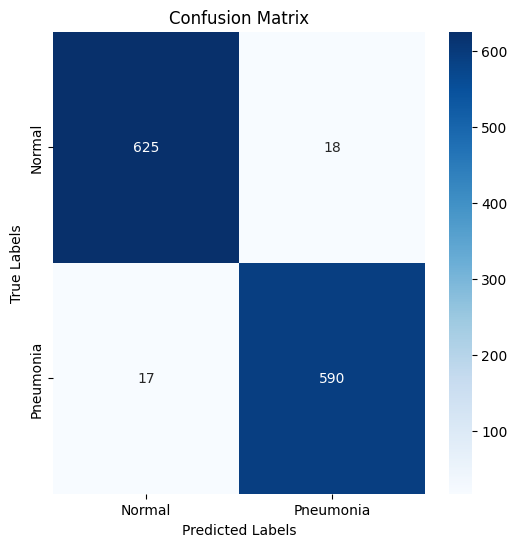

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       643
   Pneumonia       0.97      0.97      0.97       607

    accuracy                           0.97      1250
   macro avg       0.97      0.97      0.97      1250
weighted avg       0.97      0.97      0.97      1250



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert test data to RGB (3 channels)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

# Normalize the test data (same normalization used for training and validation data)
x_test_norm = x_test_rgb / 255.0

# Predict on the test set
y_test_pred = model.predict(x_test_norm)

# Convert the predictions to class labels
y_test_pred = np.argmax(y_test_pred, axis=1)  # Get class predictions

# Since y_test is already in integer format (not one-hot encoded), you can directly use it
y_test_class = y_test  # No need to convert if it's already in label form

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_test_class, y_test_pred, target_names=['Normal', 'Pneumonia'])
print("Classification Report:\n", report)


# CNN


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Build a simple CNN model
def build_cnn_model(input_shape):
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the layers
    model.add(layers.Flatten())

    # Fully connected (Dense) Layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output Layer (binary classification: normal or pneumonia)
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the input shape for your images (150x150x3)
input_shape = (150, 150, 3)

# Build the model
cnn_model = build_cnn_model(input_shape)

# Display the model summary
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert grayscale to RGB (3 channels)
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
x_val_rgb = np.repeat(x_val[..., np.newaxis], 3, axis=-1)

# Normalize the image data to the range [0, 1]
x_train_norm = x_train_rgb / 255.0
x_val_norm = x_val_rgb / 255.0

# Train the CNN model using the normalized data
history = cnn_model.fit(
    x_train_norm, y_train,  # Training data and labels
    epochs=5,              # Number of epochs to train
    batch_size=16,          # Batch size
    validation_data=(x_val_norm, y_val),  # Validation data and labels
    verbose=1               # Verbosity level
)

Epoch 1/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7018 - loss: 0.5292 - val_accuracy: 0.9296 - val_loss: 0.1941
Epoch 2/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9316 - loss: 0.2049 - val_accuracy: 0.9216 - val_loss: 0.1933
Epoch 3/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9380 - loss: 0.1691 - val_accuracy: 0.9520 - val_loss: 0.1417
Epoch 4/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9517 - loss: 0.1423 - val_accuracy: 0.9600 - val_loss: 0.1235
Epoch 5/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9497 - loss: 0.1362 - val_accuracy: 0.9632 - val_loss: 0.1165


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


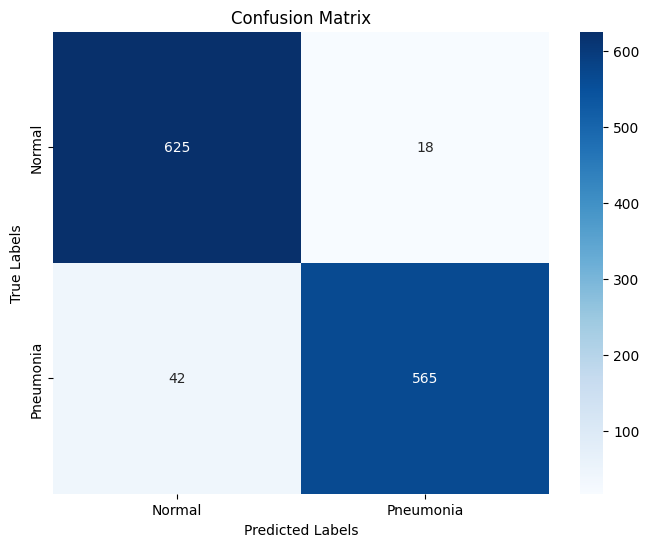

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95       643
   Pneumonia       0.97      0.93      0.95       607

    accuracy                           0.95      1250
   macro avg       0.95      0.95      0.95      1250
weighted avg       0.95      0.95      0.95      1250



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the test data using the same method as the training data (Convert grayscale to RGB and normalize)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=-1)
x_test_norm = x_test_rgb / 255.0  # Normalize to range [0, 1]

# Predict on the normalized test data
y_test_pred = cnn_model.predict(x_test_norm)

# Convert probabilities to binary class predictions (0 or 1)
y_test_pred_class = (y_test_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_class)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_class, target_names=['Normal', 'Pneumonia']))
